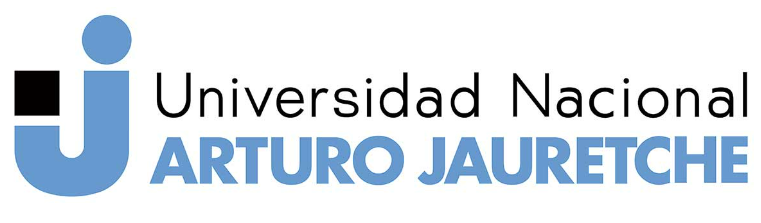
######      Trabajo Practico Final - Captura de la información
######      Diplomatura de Vinculación Introducción a la Ciencias de Datos 
######      Universidad Nacional Arturo Jaureche.
######      Alumna: Marianela Pi.


In [108]:
#Una vez que tenemos todas las librerías, vamos a empezar importarlas
import requests
from bs4 import BeautifulSoup as bs4
import pandas as pd
from datetime import datetime,date
import spacy
from nltk.stem import WordNetLemmatizer
nlp = spacy.load("es_core_news_sm")
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re

# Introducción

**Scraping de Noticias:** Se abordará el proceso de obtención de información relevante a través del scraping de noticias, con un enfoque Político, pero podemos extraer cualquier sección del diario infobae. Exploraremos cómo extraer datos de fuentes en línea.

# Desarrollo

## Scraping
#### **Extracción básica de texto en la Web.**

Cuando trabajamos con *scraping*, tenemos que considerar la interpretación del *código* HTML. Este tipo de lenguaje es en el que se encuentran enmarcadas las plataformas y su correcto entendimiento nos va a permitir ir a buscar el texto o información que estamos buscando.

En este sentido, lo primero que debemos hacer es traernos el *HTML* entero que queremos inspeccionar.

In [109]:
# extraemos la respuesta del parametro que le pasamos, en este caso la url de infobae
response = requests.get (url='https://www.infobae.com/politica/')

In [110]:
# transformamos la respuesta que nosotros le pasamos
texto_html = bs4(response.text,'lxml')

In [111]:
# Buscar el primer párrafo en la clase 'deck-first'
primer_parrafo = texto_html.find('div', class_='deck-first').get_text()


In [112]:
# Buscar todos los párrafos en la clase 'deck'
parrafos = texto_html.find_all('div', class_='deck')

In [113]:
# Obtener el texto de los párrafos y almacenarlos en una lista
lista_parrafos = [parrafo.get_text() for parrafo in parrafos]

In [114]:
# Obtener todos los elementos h2
titulo_tags = texto_html.find_all('h2', class_='feed-list-card-headline-lean')
lista_titulos = [titulo.text for titulo in titulo_tags]

# Me Aseguro de que las listas tengan la misma longitud
min_length = min(len(lista_parrafos), len(lista_titulos))
lista_parrafos = lista_parrafos[:min_length]
lista_titulos = lista_titulos[:min_length]

df_parrafos = pd.DataFrame({'parrafo': lista_parrafos, 'titulo': lista_titulos})

# Filtrar las primeras 5 noticias
df_parrafos.head(10)


,parrafo,titulo
0,El presidente de la Nación reveló cuáles serán...,Javier Milei encabezó en Casa Rosada una nueva...
1,El Presidente está en la Casa Rosada desde tem...,Milei confía en que el DNU tuvo una buena rece...
2,El ex presidente aprovechó para expresarse sob...,Alberto Fernández anunció que viajará a España...
3,El DNU anunciado por Javier Milei para desregu...,¿Qué son y cuándo habrá sesiones extraordinari...
4,Los legisladores buscan reunir los votos. Los ...,Los legisladores kirchneristas se reunieron co...
5,El Presidente eligió que lo acompañen la mayor...,Quién es quién: los funcionarios y asesores qu...
6,El vocero presidencial Manuel Adorni adelantó ...,El Gobierno les cobrará al Polo Obrero y a Uni...
7,El ex secretario de Comercio Interior le dijo ...,La definición de Guillermo Moreno tras el DNU ...
8,"Se trata de Marcelo Suárez Salvia, un diplomát...","En un gesto de distensión política, Milei desi..."
9,El gobernador entrerriano heredó un deuda de 2...,Rogelio Frigerio acordó con el gremio de la co...


In [115]:
# Calcular la cantidad de palabras de los párrafos y agregar una columna al DataFrame
df_parrafos['cant._palabras'] = df_parrafos['parrafo'].apply(lambda x: len(x.split()))

In [116]:
df_parrafos.head(10)

,parrafo,titulo,cant._palabras
0,El presidente de la Nación reveló cuáles serán...,Javier Milei encabezó en Casa Rosada una nueva...,23
1,El Presidente está en la Casa Rosada desde tem...,Milei confía en que el DNU tuvo una buena rece...,46
2,El ex presidente aprovechó para expresarse sob...,Alberto Fernández anunció que viajará a España...,18
3,El DNU anunciado por Javier Milei para desregu...,¿Qué son y cuándo habrá sesiones extraordinari...,23
4,Los legisladores buscan reunir los votos. Los ...,Los legisladores kirchneristas se reunieron co...,24
5,El Presidente eligió que lo acompañen la mayor...,Quién es quién: los funcionarios y asesores qu...,25
6,El vocero presidencial Manuel Adorni adelantó ...,El Gobierno les cobrará al Polo Obrero y a Uni...,26
7,El ex secretario de Comercio Interior le dijo ...,La definición de Guillermo Moreno tras el DNU ...,39
8,"Se trata de Marcelo Suárez Salvia, un diplomát...","En un gesto de distensión política, Milei desi...",42
9,El gobernador entrerriano heredó un deuda de 2...,Rogelio Frigerio acordó con el gremio de la co...,17


#### Escritura de archivo tipo Texto.
Las noticias descargadas las descargamos en un archivo tipo texto. 

In [117]:
# Guardar los datos en un archivo de texto
archivo_salida = 'Ultimas_noticias_de_Politica.txt'
with open(archivo_salida, 'w', encoding='utf-8') as archivo:
    for index, row in df_parrafos.head(10).iterrows():
        archivo.write(f"Título: {row['titulo']}\n")
        archivo.write(f"Párrafo: {row['parrafo']}\n")
        archivo.write("-" * 50 + "\n")

print(f"Los datos de las primeras 5 noticias se han guardado en el archivo '{archivo_salida}'")

Los datos de las primeras 5 noticias se han guardado en el archivo 'Ultimas_noticias_de_Politica.txt'


#### Corpus entero.
Elaboramos un data frame en donde cada fila corresponde a un párrafo de cada noticia.

In [118]:
# Definir la función para procesar un párrafo
def procesar_parrafo(parrafo):
    doc = nlp(parrafo)
    palabras_lematizadas = [token.lemma_ for token in doc]
    entidades = [ent.text for ent in doc.ents]
    return palabras_lematizadas, entidades



In [119]:
# Crear un DataFrame con los datos
df_parrafos = pd.DataFrame({'parrafo': lista_parrafos, 'titulo': lista_titulos})
df_parrafos['cant_palabras'] = df_parrafos['parrafo'].apply(lambda x: len(x.split()))

# Utiliza la función apply para aplicar procesar_parrafo a cada parrafo
df_parrafos[['terminos_lematizados', 'entidad']] = df_parrafos['parrafo'].apply(lambda x: pd.Series(procesar_parrafo(x) if x else ([], [])))

df_parrafos.head()

,parrafo,titulo,cant_palabras,terminos_lematizados,entidad
0,El presidente de la Nación reveló cuáles serán...,Javier Milei encabezó en Casa Rosada una nueva...,23,"[el, presidente, de, el, Nación, revelar, cuál...","[Nación, Decreto de Necesidad, Urgencia]"
1,El Presidente está en la Casa Rosada desde tem...,Milei confía en que el DNU tuvo una buena rece...,46,"[el, Presidente, estar, en, el, Casa, Rosada, ...","[Presidente, Casa Rosada, anoche, Salió, Plaza..."
2,El ex presidente aprovechó para expresarse sob...,Alberto Fernández anunció que viajará a España...,18,"[el, ex, presidente, aprovechar, para, expresa...",[Javier Milei]
3,El DNU anunciado por Javier Milei para desregu...,¿Qué son y cuándo habrá sesiones extraordinari...,23,"[el, DNU, anunciado, por, Javier, Milei, para,...","[DNU, Javier Milei, En qué]"
4,Los legisladores buscan reunir los votos. Los ...,Los legisladores kirchneristas se reunieron co...,24,"[el, legislador, buscar, reunir, el, voto, ., ...","[Los sidnicalistas, los “]"


Realizamos un gráfico nube de palabras con las palabras más relevantes de las noticias de Política

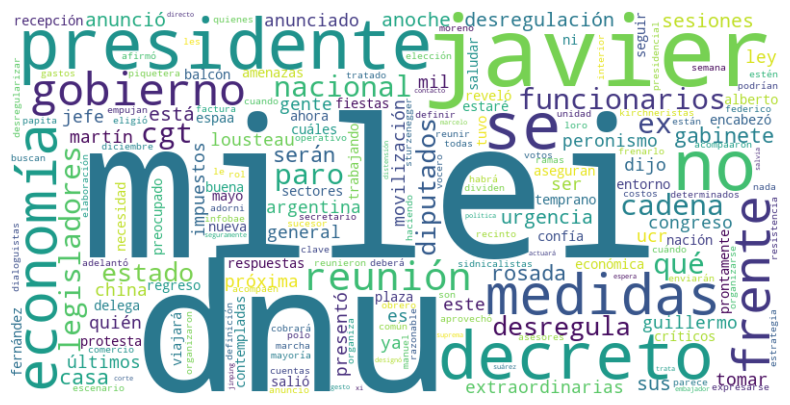

In [122]:
# Lista de palabras comunes a excluir
palabras_excluidas = {'un', 'tiene','hay','pero','lo','que', 'desde', 'en', 'a', 'su','de','una', 'unos', 'unas', 'el', 'la', 'los', 'las', 'y', 'del', 'al', 'con', 'para', 'por', 'sin', 'sobre', 'entre', 'tras', 'durante', 'hasta', 'como', 'según', 'aunque', 'si', 'porque'}

# Combina títulos y párrafos en una sola cadena de texto
texto_completo = ' '.join(df_parrafos['titulo'] + ' ' + df_parrafos['parrafo'])

# Elimina caracteres no deseados y convierte a minúsculas
texto_completo = re.sub(r'[^a-zA-Z\sáéíóúÁÉÍÓÚ]', '', texto_completo).lower()

# Elimina palabras comunes
palabras = [palabra for palabra in texto_completo.split() if palabra not in palabras_excluidas]

# Cuenta la frecuencia de cada palabra
frecuencias = Counter(palabras)

# Configura el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate_from_frequencies(frecuencias)

# Visualiza la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()